In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)

os.chdir('/home/brian/Documents/CPS/data/clean/')

rec_dates = [('1990-08-01', '1991-04-01'),
             ('2001-04-01', '2001-12-01'),
             ('2008-01-01', '2009-07-01'),
             ('2020-03-01', '2020-07-01')]

### Overview of labor force status

In [2]:
cols = ['MONTH', 'YEAR', 'LFS', 'BASICWGT', 'AGE', 'FEMALE']

date_cols = ['YEAR', 'MONTH', 'DAY']

date = lambda x: pd.to_datetime(x[['YEAR', 'MONTH', 'DAY']])

df = (pd.concat([pd.read_feather(f'cps{year}.ft', columns=cols) 
                 for year in range(1989, 2021)])
        .query('BASICWGT > 0 and AGE >= 16')
        .assign(DAY = 1, DATE = date)
        .drop(date_cols, axis=1))

In [3]:
lfs_cats = ['Employed', 'Unemployed', 'NILF']

data = (df.groupby(['DATE', 'LFS']).BASICWGT.sum()
          .unstack().drop('nan', axis=1))

data.columns = pd.Index(list(data.columns))

data['Total'] = data.sum(axis=1)

contrib = data[lfs_cats].divide(data.Total, axis=0) * 100

ch = contrib.diff(12).dropna()

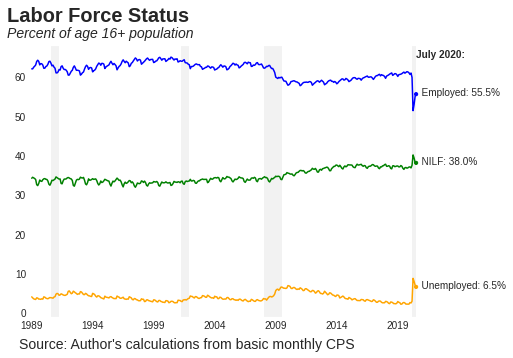

In [4]:
colors = ['blue', 'orange', 'green']

contrib.index.name = ''

contrib.plot(figsize=(7, 5), color=colors, legend=None, xlabel=None)

ax = plt.scatter([contrib.index[-1]] * 3, contrib.iloc[-1].values,
                 color=colors, s=10)
for i, txt in enumerate(contrib.iloc[-1].values):
    ax = plt.annotate(f'  {contrib.iloc[-1].index[i]}: {txt:.1f}%', 
                      (contrib.index[-1], txt-0.25))
ax = plt.annotate(f'{contrib.index[-1]:%B %Y}: ', 
                  (contrib.index[-1], 
                   contrib.max().max()), 
                  fontweight='bold')

ax = plt.xlim(pd.to_datetime('1988-11-01'), pd.to_datetime('2020-11-01'))

# Shaded bars indicating recessions
for peak, trough in rec_dates:
    plt.axvspan(peak, trough, fill=True, zorder=0,
                linewidth=0, color='gray', alpha=0.1)  
    
# add title and footer
plt.text('1987', 74, 'Labor Force Status', 
          fontsize=20, weight='bold')

plt.text('1987', 70, "Percent of age 16+ population", 
          fontsize=14, style='italic')

plt.text('1988', -9, "Source: Author's calculations from basic monthly CPS", 
          fontsize=14);

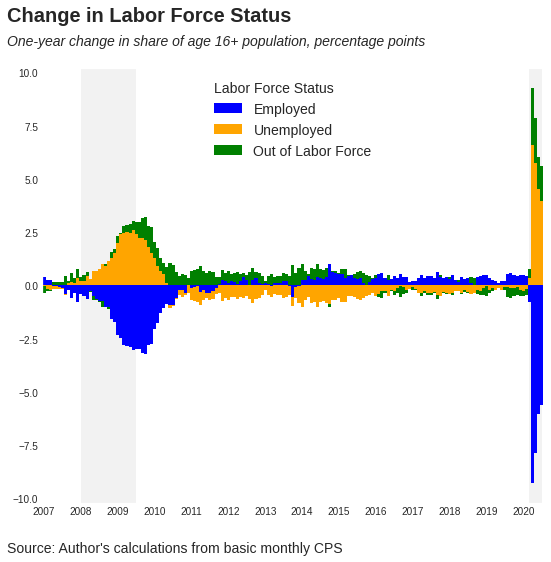

In [5]:
ch = ch.loc['2007':].rename({'NILF': 'Out of Labor Force'}, axis=1)

ch.index.name = ''
ch.name = ''
def line_format(index):
    label = ''
    if index.month_name()[:3] == 'Jan':
        label += f'{index.year}'
    return label

ax = ch.plot(kind='bar', stacked=True, figsize=(9, 8), 
            rot=0, width=1, color=colors)
plt.legend(loc="upper left", framealpha=1)
ax.set_xticklabels(map(lambda x: line_format(x), ch.index))

# Shaded bars indicating recessions
for peak, trough in rec_dates[2:]:
    pk = ch.index.to_list().index(pd.to_datetime(peak))
    tr = ch.index.to_list().index(pd.to_datetime(trough))
    plt.axvspan(pk, tr, fill=True, zorder=0,
                linewidth=0, color='gray', alpha=0.1)
    
leg = plt.legend(loc="upper center", fontsize=14, ncol=1, 
                 title='Labor Force Status', title_fontsize=14)

leg._legend_box.align = "left"

# add title and footer
plt.text(-12, 12.4, 'Change in Labor Force Status', 
          fontsize=20, weight='bold')

plt.text(-12, 11.3, "One-year change in share of age 16+ population, percentage points", 
          fontsize=14, style='italic')

plt.text(-12, -12.5, "Source: Author's calculations from basic monthly CPS", 
          fontsize=14);

### Closer look at COVID-19 period compared to year prior

In [6]:
cols = ['MONTH', 'YEAR', 'AGE', 'FEMALE', 'LFS', 'NOTATWORK', 
        'NILFREASON', 'PTECON', 'WORKFT', 'BASICWGT', 'MJH',
        'LAYOFF']

age_grp = lambda x: pd.cut(x.AGE, list(range(16, 83, 6)))

femp = lambda x: np.where((x.WORKFT == 1) | 
                          ((x.LFS == 'Employed') & 
                           (x.PTECON == 0) & 
                           (x.NOTATWORK == 0)), 1, 0)

emptype = lambda x: np.where(x.MJH == 1, 'MJH', 
                    np.where(x.FEMP == 1, 'FEMP',
                    np.where(x.PTECON == 1, 'PTECON',
                    np.where(x.NOTATWORK == 1, 'NOTATWORK', 0))))

master = lambda x: pd.Categorical(
                    np.where(x.LFS == 'Employed', x.EMPTYPE,
                    np.where(x.LFS == 'NILF', x.NILFREASON,
                    np.where(x.LFS == 'Unemployed', x.LAYOFF, np.nan))))

df = (pd.concat([pd.read_feather(f'cps{year}.ft', columns=cols) 
                 for year in range(2019, 2021)])
        .query('BASICWGT > 0 and AGE >= 16 and FEMALE == 1')
        .assign(DAY = 1, DATE = date, AGE_GRP = age_grp,
                FEMP = femp, EMPTYPE = emptype, MASTER = master)
        .drop(date_cols, axis=1))

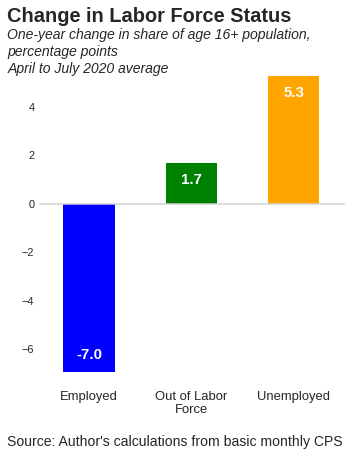

In [7]:
pre_start, pre_end = '2019-04-01', '2019-07-01'
cov_start, cov_end = '2020-04-01', '2020-07-01'

pre = df.query('DATE >= @pre_start and DATE <= @pre_end')
cov = df.query('DATE >= @cov_start and DATE <= @cov_end')
    
co = (cov.groupby('LFS').BASICWGT.sum() / cov.BASICWGT.sum())
pr = (pre.groupby('LFS').BASICWGT.sum() / pre.BASICWGT.sum())

ltdt = ((co - pr).drop('nan') * 100).rename({'NILF': 'Out of Labor\nForce'}, axis=1)
ltdt.index.name = ''
ltdt.plot(kind='bar', color=['blue', 'green', 'orange'], 
          rot=0, figsize=(5.5, 6))
plt.axhline(y=0, color='lightgray')


# Value labels
for i, name in enumerate(ltdt.index):
    offset = 0.7
    if ltdt[name] < 0:
        offset = -offset
    txt = f'{ltdt[name]:.1f}'
    loc = (i, ltdt[name] - offset)
    plt.text(loc[0], loc[1], txt, color='white', 
             fontsize=15, weight='bold', ha='center', va='center')

plt.xticks(fontsize=13)
plt.yticks(fontsize=11) 

# add title and footer
plt.text(-0.8, 7.5, 'Change in Labor Force Status', 
          fontsize=20, weight='bold')

plt.text(-0.8, 6.8, "One-year change in share of age 16+ population,", 
          fontsize=14, style='italic')
plt.text(-0.8, 6.1, "percentage points", 
          fontsize=14, style='italic')
plt.text(-0.8, 5.4, "April to July 2020 average", 
          fontsize=14, style='italic')

plt.text(-0.8, -10, "Source: Author's calculations from basic monthly CPS", 
          fontsize=14);

### By Age

No handles with labels found to put in legend.


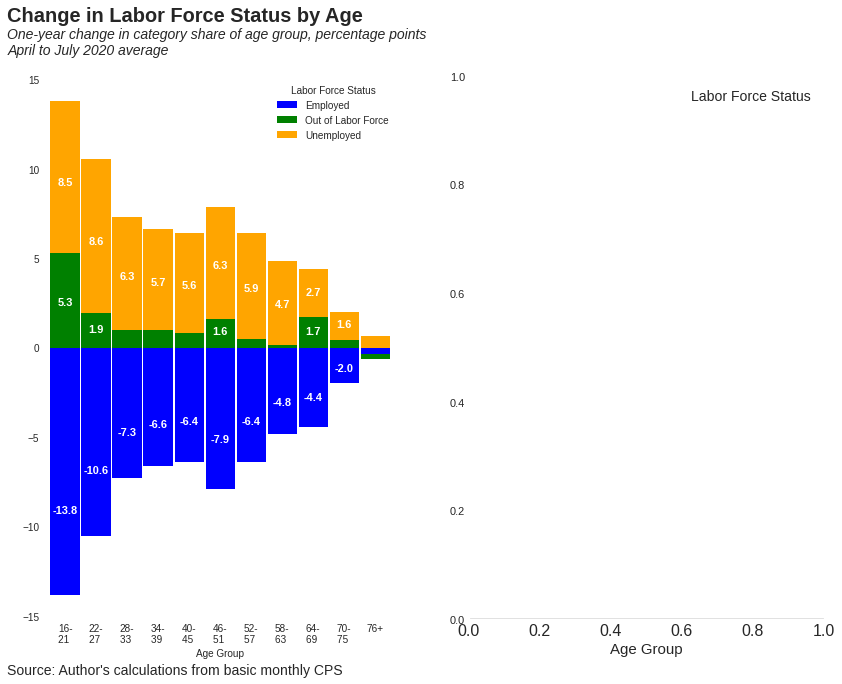

In [8]:
co = (cov.groupby(['AGE_GRP', 'LFS']).BASICWGT.sum() / 
      cov.groupby('AGE_GRP').BASICWGT.sum())
pr = (pre.groupby(['AGE_GRP', 'LFS']).BASICWGT.sum() / 
      pre.groupby('AGE_GRP').BASICWGT.sum())

agedt = ((co - pr).unstack().drop('nan', axis=1).dropna() * 100)

result = agedt
result = result.rename({'NILF': 'Out of Labor Force'}, axis=1)
result.name = ''
idx = [f'{i.left}-\n{i.right - 1} ' for i in result.index]
idx[-1] = f'{idx[-1][:2]}+'
result.index = idx
result.index.name = 'Age Group'
result.columns.name = 'Labor Force Status'


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 10))

result.plot(kind='bar', stacked=True, ax=axes[0],
            color=['blue', 'green', 'orange'], 
            width=0.95, rot=0)

plt.axhline(y=0, color='lightgray')

for cat in result.columns:
    for i, age_group in enumerate(result.index):
        offset = (result.max().max() - result.min().min()) / 10
        val = result.loc[age_group, cat]
        if val < 0:
            offset = offset * (2/3)
        loc = (i, (val / offset))
        if cat == 'Unemployed':
            nilf_val = result.loc[age_group, 'Out of Labor Force']
            loc = (i, (val / offset) + nilf_val)
        if abs(val) > 1:
            txt = f'{val:.1f}'
        else:
            txt = ''
        plt.text(loc[0], loc[1], txt, color='white', transform=axes[0].transData,
                 fontsize=11, weight='bold', ha='center')
        
plt.xticks(fontsize=16)
plt.yticks(fontsize=11)
plt.xlabel('Age Group', fontsize=15)
leg = plt.legend(loc="upper right", fontsize=15, ncol=1,
                 title='Labor Force Status', title_fontsize=14)

# add title and footer
plt.text(-1.3, 1.1, 'Change in Labor Force Status by Age', 
          fontsize=20, weight='bold')

plt.text(-1.3, 1.07, "One-year change in category share of age group, percentage points", 
          fontsize=14, style='italic')
plt.text(-1.3, 1.04, "April to July 2020 average", 
          fontsize=14, style='italic')

plt.text(-1.3, -0.1, "Source: Author's calculations from basic monthly CPS", 
          fontsize=14);

### Employment Type

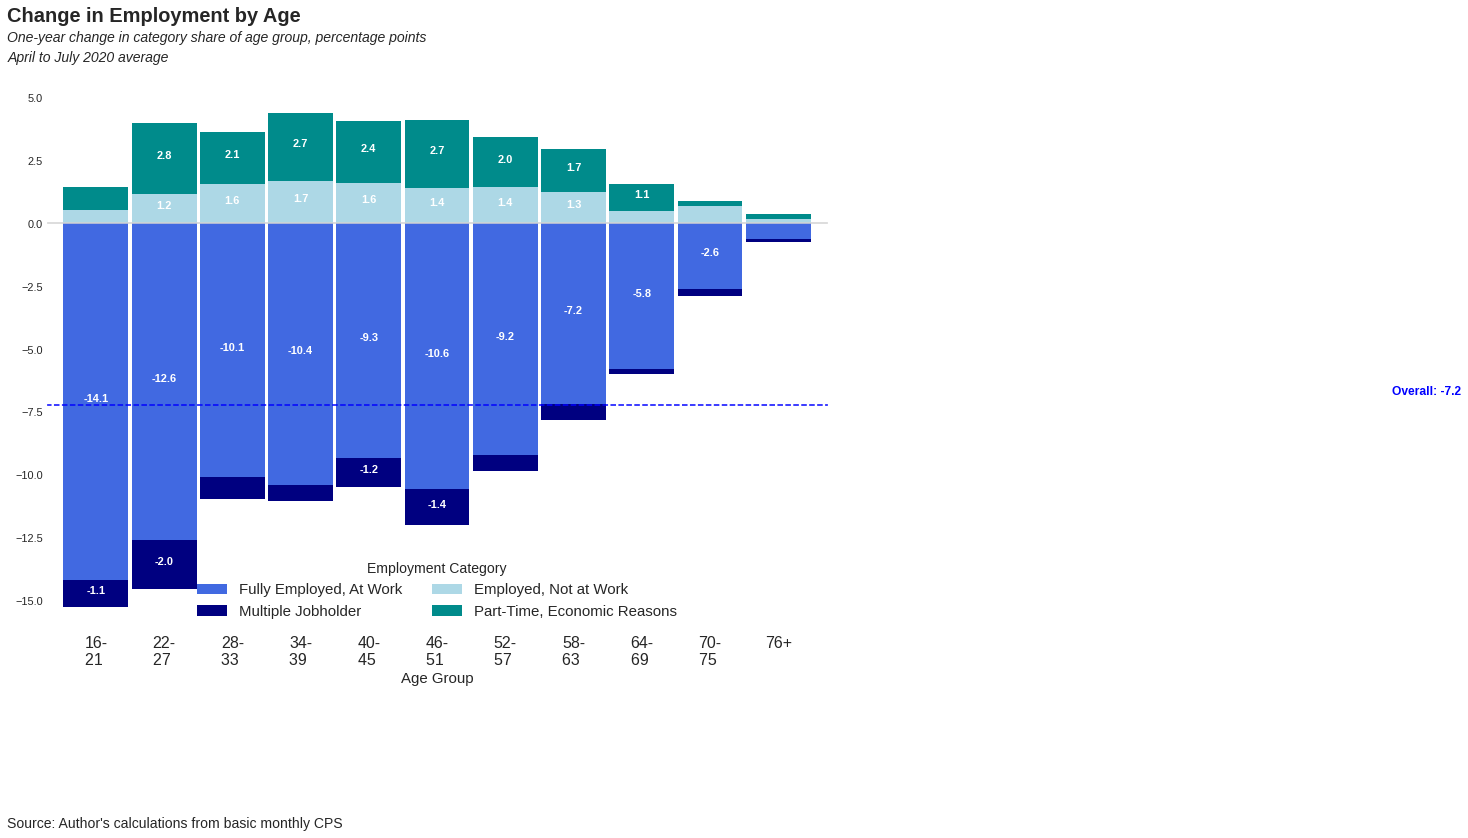

In [9]:
co = (cov.groupby(['AGE_GRP', 'EMPTYPE']).BASICWGT.sum() / 
      cov.groupby('AGE_GRP').BASICWGT.sum())
pr = (pre.groupby(['AGE_GRP', 'EMPTYPE']).BASICWGT.sum() / 
      pre.groupby('AGE_GRP').BASICWGT.sum())

empdt = (((co - pr).unstack().drop('0', axis=1).dropna() * 100)
         .rename({'FEMP': 'Fully Employed, At Work', 'MJH': 'Multiple Jobholder', 
                  'NOTATWORK': 'Employed, Not at Work', 
                  'PTECON': 'Part-Time, Economic Reasons'}, axis=1))

empdt.name = ''
idx = [f'{i.left}-\n{i.right - 1} ' for i in empdt.index]
idx[-1] = f'{idx[-1][:2]}+'
empdt.index = idx
empdt.index.name = 'Age Group'
empdt.columns.name = 'Employment'

empdt.plot(kind='bar', stacked=True, 
           color=['royalblue', 'navy', 'lightblue', 'darkcyan'], 
           width=0.95, rot=0, figsize=(14, 10))


labels = []

# Negative values
for x, (name, row) in enumerate(empdt[empdt < 0].iterrows()):
    row = row.dropna()
    cs = row.cumsum() - (row / 2)
    for i in cs.iteritems():
        if abs(row.loc[i[0]]) > 0.9:
            y = i[1]
            val = f'{row.loc[i[0]]:.1f}'
            labels.append((x, y, val))
    
# Positive values
for x, (name, row) in enumerate(empdt[empdt >= 0].iterrows()):
    row = row.dropna()
    cs = row.cumsum() - (row / 2)
    for i in cs.iteritems():
        if abs(row.loc[i[0]]) > 0.9:
            y = i[1]
            val = f'{row.loc[i[0]]:.1f}'
            labels.append((x, y, val))

for (x, y, val) in labels:  
    plt.text(x, y, val, color='white', 
             fontsize=11, weight='bold', ha='center')            

plt.axhline(y=0, color='lightgray')

plt.axhline(y=-7.2, color='blue', linestyle='--')

plt.xticks(fontsize=16)
plt.yticks(fontsize=11)
plt.xlabel('Age Group', fontsize=15)
plt.legend(loc="lower center", fontsize=15, ncol=2,
           title='Employment Category', title_fontsize=14)

plt.text(19, -6.8, 'Overall: -7.2', color='blue', fontsize=12, weight='bold')     

leg._legend_box.align = "left"

# add title and footer
plt.text(-1.3, 8, 'Change in Employment by Age', 
          fontsize=20, weight='bold')
9
plt.text(-1.3, 7.2, "One-year change in category share of age group, percentage points", 
          fontsize=14, style='italic')
plt.text(-1.3, 6.4, "April to July 2020 average", 
          fontsize=14, style='italic')

plt.text(-1.3, -24, "Source: Author's calculations from basic monthly CPS", 
          fontsize=14);

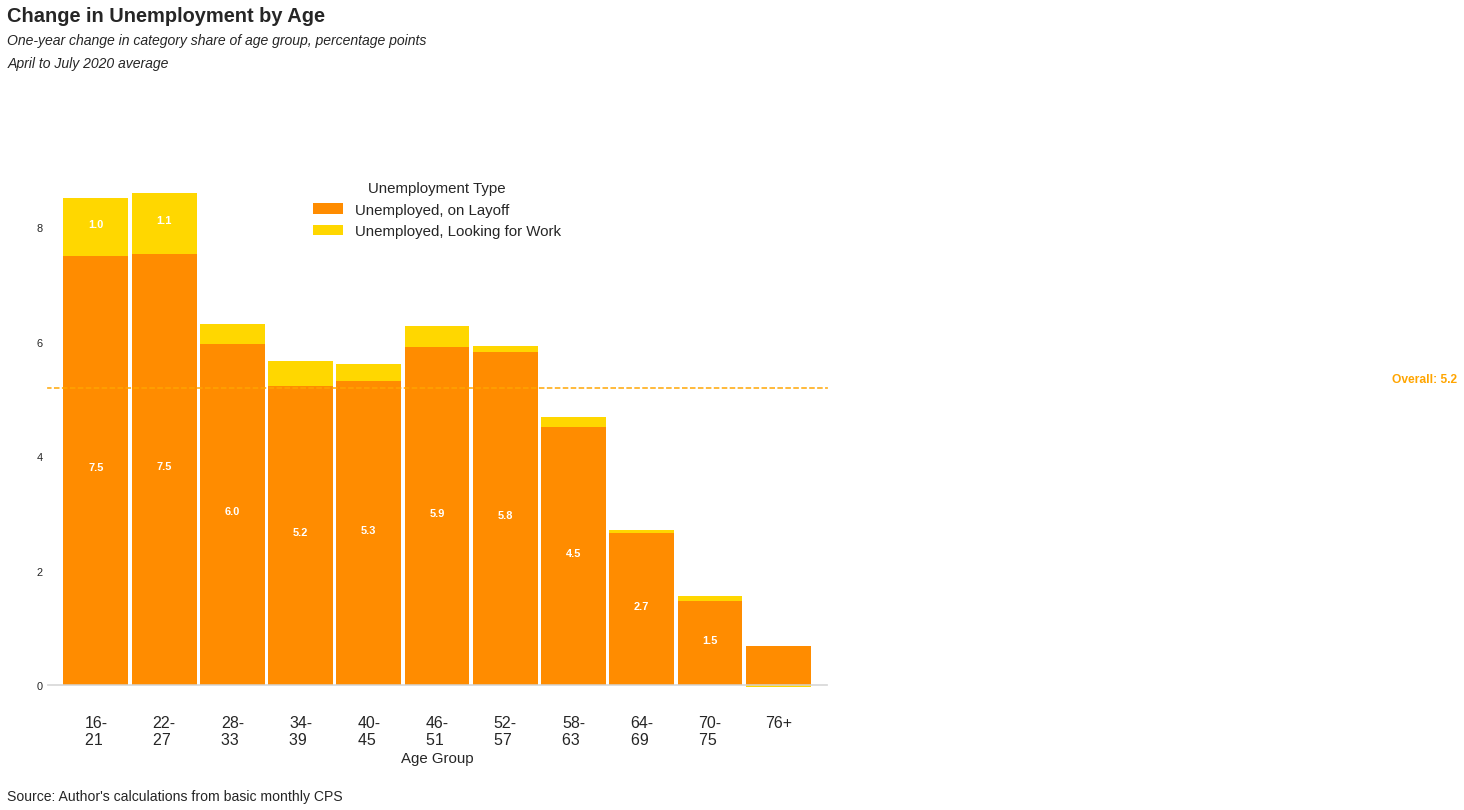

In [10]:
co = (cov.groupby(['AGE_GRP', 'LAYOFF']).BASICWGT.sum() / 
      cov.groupby('AGE_GRP').BASICWGT.sum())
pr = (pre.groupby(['AGE_GRP', 'LAYOFF']).BASICWGT.sum() / 
      pre.groupby('AGE_GRP').BASICWGT.sum())

undt = (((co - pr).unstack().drop('nan', axis=1).dropna() * 100)
         .rename({'Layoff': 'Unemployed, on Layoff', 
                  'Looking': 'Unemployed, Looking for Work'}, axis=1))

undt.name = ''
idx = [f'{i.left}-\n{i.right - 1} ' for i in undt.index]
idx[-1] = f'{idx[-1][:2]}+'
undt.index = idx
undt.index.name = 'Age Group'
undt.columns.name = 'Unemployment'

undt.plot(kind='bar', stacked=True, 
           color=['darkorange', 'gold'], 
           width=0.95, rot=0, figsize=(14, 10))


labels = []

# Negative values
for x, (name, row) in enumerate(undt[undt < 0].iterrows()):
    row = row.dropna()
    cs = row.cumsum() - (row / 2)
    for i in cs.iteritems():
        if abs(row.loc[i[0]]) > 0.9:
            y = i[1]
            val = f'{row.loc[i[0]]:.1f}'
            labels.append((x, y, val))
    
# Positive values
for x, (name, row) in enumerate(undt[undt >= 0].iterrows()):
    row = row.dropna()
    cs = row.cumsum() - (row / 2)
    for i in cs.iteritems():
        if abs(row.loc[i[0]]) > 0.9:
            y = i[1]
            val = f'{row.loc[i[0]]:.1f}'
            labels.append((x, y, val))

for (x, y, val) in labels:  
    plt.text(x, y, val, color='white', 
             fontsize=11, weight='bold', ha='center')            

plt.axhline(y=0, color='lightgray')

plt.axhline(y=5.2, color='orange', linestyle='--')

plt.xticks(fontsize=16)
plt.yticks(fontsize=11)
plt.xlabel('Age Group', fontsize=15)
plt.legend(loc="upper center", fontsize=15, ncol=1,
           title='Unemployment Type', title_fontsize=15)

plt.text(19, 5.3, 'Overall: 5.2', color='orange', fontsize=12, weight='bold')     

leg._legend_box.align = "left"

# add title and footer
plt.text(-1.3, 11.6, 'Change in Unemployment by Age', 
          fontsize=20, weight='bold')
9
plt.text(-1.3, 11.2, "One-year change in category share of age group, percentage points", 
          fontsize=14, style='italic')
plt.text(-1.3, 10.8, "April to July 2020 average", 
          fontsize=14, style='italic')

plt.text(-1.3, -2, "Source: Author's calculations from basic monthly CPS", 
          fontsize=14);

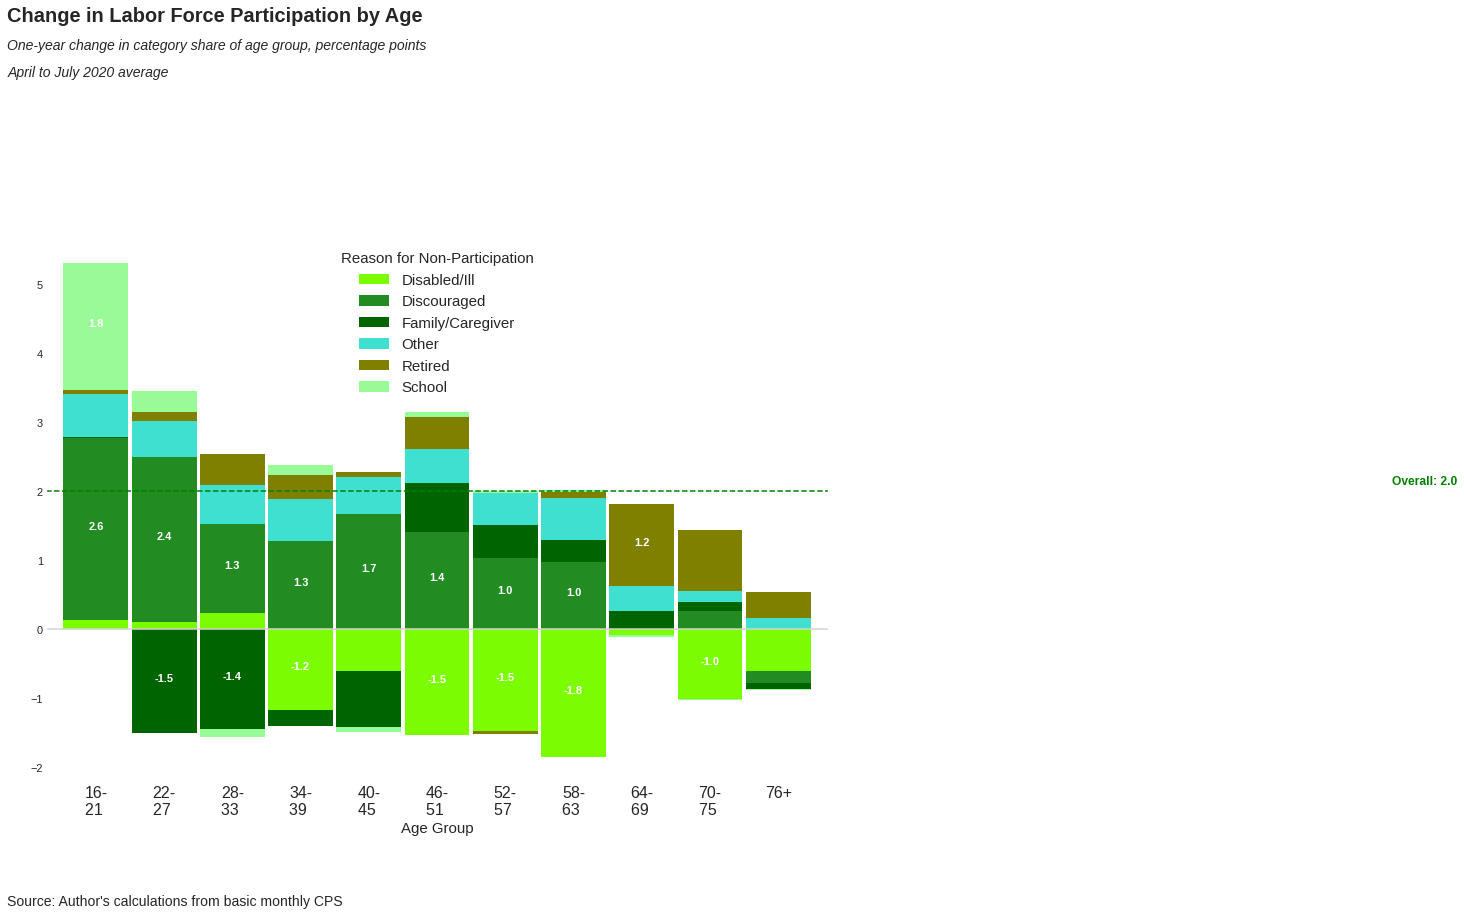

In [11]:
co = (cov.groupby(['AGE_GRP', 'NILFREASON']).BASICWGT.sum() / 
      cov.groupby('AGE_GRP').BASICWGT.sum())
pr = (pre.groupby(['AGE_GRP', 'NILFREASON']).BASICWGT.sum() / 
      pre.groupby('AGE_GRP').BASICWGT.sum())

nilfdt = (((co - pr).unstack().drop('nan', axis=1).dropna() * 100)
           .rename({'Family': 'Family/Caregiver'}, axis=1))

nilfdt.name = ''
idx = [f'{i.left}-\n{i.right - 1} ' for i in nilfdt.index]
idx[-1] = f'{idx[-1][:2]}+'
nilfdt.index = idx
nilfdt.index.name = 'Age Group'
nilfdt.columns.name = 'Out of Labor Force'

nilfdt.plot(kind='bar', stacked=True, 
           color=['lawngreen', 'forestgreen', 'darkgreen', 'turquoise', 'olive', 'palegreen'], 
           width=0.95, rot=0, figsize=(14, 10))


labels = []

# Negative values
for x, (name, row) in enumerate(nilfdt[nilfdt < 0].iterrows()):
    row = row.dropna()
    cs = row.cumsum() - (row / 2)
    for i in cs.iteritems():
        if abs(row.loc[i[0]]) > 0.9:
            y = i[1]
            val = f'{row.loc[i[0]]:.1f}'
            labels.append((x, y, val))
    
# Positive values
for x, (name, row) in enumerate(nilfdt[nilfdt >= 0].iterrows()):
    row = row.dropna()
    cs = row.cumsum() - (row / 2)
    for i in cs.iteritems():
        if abs(row.loc[i[0]]) > 0.9:
            y = i[1]
            val = f'{row.loc[i[0]]:.1f}'
            labels.append((x, y, val))

for (x, y, val) in labels:  
    plt.text(x, y, val, color='white', 
             fontsize=11, weight='bold', ha='center')            

plt.axhline(y=0, color='lightgray')

plt.axhline(y=2.0, color='green', linestyle='--')

plt.xticks(fontsize=16)
plt.yticks(fontsize=11)
plt.xlabel('Age Group', fontsize=15)
plt.legend(loc="upper center", fontsize=15, ncol=1,
           title='Reason for Non-Participation', title_fontsize=15)

plt.text(19, 2.1, 'Overall: 2.0', color='green', fontsize=12, weight='bold')     

leg._legend_box.align = "left"

# add title and footer
plt.text(-1.3, 8.8, 'Change in Labor Force Participation by Age', 
          fontsize=20, weight='bold')
9
plt.text(-1.3, 8.4, "One-year change in category share of age group, percentage points", 
          fontsize=14, style='italic')
plt.text(-1.3, 8.0, "April to July 2020 average", 
          fontsize=14, style='italic')

plt.text(-1.3, -4, "Source: Author's calculations from basic monthly CPS", 
          fontsize=14);

In [12]:
query_str = 'AGE > 15'

dfa = df.query(query_str)

pre = dfa.query('DATE >= @pre_start and DATE <= @pre_end')
cov = dfa.query('DATE >= @cov_start and DATE <= @cov_end')

pre_data = ((pre.groupby('MASTER').BASICWGT.sum() / pre.BASICWGT.sum()) * 100)
cov_data = ((cov.groupby('MASTER').BASICWGT.sum() / cov.BASICWGT.sum()) * 100)
result = pd.DataFrame({'April to July 2019': pre_data, 
                       'April to July 2020': cov_data})

d = {'Layoff': 'Unemployed, on Layoff', 
     'Looking': 'Unemployed, Looking for Work', 
     'Family': 'Out of Labor Force, Family/Caregiver',
     'FEMP': 'Fully Employed, At Work', 
     'MJH': 'Employed, Multiple Jobholder', 
     'NOTATWORK': 'Employed, Not at Work', 
     'PTECON': 'Employed Part-Time, Economic Reasons',
     'Disabled/Ill': 'Out of Labor Force, Disability or Illness',
     'Retired': 'Out of Labor Force, Retired',
     'Other': 'Out of Labor Force, Other Unspecified Reason',
     'School': 'Out of Labor Force, School',
     'Discouraged': 'Out of Labor Force, Discouraged'}

data = result.rename(d)
data.index.name = ''

data['Difference'] = data['April to July 2020'] - data['April to July 2019']

data = data.sort_values('Difference', ascending=True).applymap("{0:.1f}".format)

pre_pop = (pre.BASICWGT.sum() / 4)
cov_pop = (cov.BASICWGT.sum() / 4)
diff_pop = cov_pop - pre_pop

data.loc['Population, Age 16+', 'April to July 2019'] = f'{pre_pop.round(-3):,.0f}'
data.loc['Population, Age 16+', 'April to July 2020'] = f'{cov_pop.round(-3):,.0f}'
data.loc['Population, Age 16+', 'Difference'] = f'{diff_pop.round(-3):,.0f}'

pre_n = pre.BASICWGT.count()
cov_n = cov.BASICWGT.count()
diff_n = cov_n - pre_n

data.loc['Sample size', 'April to July 2019'] = f'{pre_n:,.0f}'
data.loc['Sample size', 'April to July 2020'] = f'{cov_n:,.0f}'
data.loc['Sample size', 'Difference'] = f'{diff_n:,.0f}'
data_all = data

In [13]:
data_all

,April to July 2019,April to July 2020,Difference
,,,
"Fully Employed, At Work",47.7,38.7,-8.9
"Employed, Multiple Jobholder",3.1,2.2,-0.9
"Out of Labor Force, Disability or Illness",5.8,5.1,-0.7
"Out of Labor Force, Family/Caregiver",8.9,8.7,-0.3
"Out of Labor Force, School",5.0,5.1,0.2
"Unemployed, Looking for Work",1.8,2.1,0.3
"Out of Labor Force, Other Unspecified Reason",0.9,1.4,0.5
"Out of Labor Force, Retired",20.3,21.2,0.8
"Employed, Not at Work",2.8,3.9,1.1


In [14]:
query_str = 'AGE > 15 and AGE < 25'

dfa = df.query(query_str)

pre = dfa.query('DATE >= @pre_start and DATE <= @pre_end')
cov = dfa.query('DATE >= @cov_start and DATE <= @cov_end')

pre_data = ((pre.groupby('MASTER').BASICWGT.sum() / pre.BASICWGT.sum()) * 100)
cov_data = ((cov.groupby('MASTER').BASICWGT.sum() / cov.BASICWGT.sum()) * 100)
result = pd.DataFrame({'April to July 2019': pre_data, 
                       'April to July 2020': cov_data})

d = {'Layoff': 'Unemployed, on Layoff', 
     'Looking': 'Unemployed, Looking for Work', 
     'Family': 'Out of Labor Force, Family/Caregiver',
     'FEMP': 'Fully Employed, At Work', 
     'MJH': 'Employed, Multiple Jobholder', 
     'NOTATWORK': 'Employed, Not at Work', 
     'PTECON': 'Employed Part-Time, Economic Reasons',
     'Disabled/Ill': 'Out of Labor Force, Disability or Illness',
     'Retired': 'Out of Labor Force, Retired',
     'Other': 'Out of Labor Force, Other Unspecified Reason',
     'School': 'Out of Labor Force, School',
     'Discouraged': 'Out of Labor Force, Discouraged'}

data = result.rename(d)
data.index.name = ''

data['Difference'] = data['April to July 2020'] - data['April to July 2019']

data = data.sort_values('Difference', ascending=True).applymap("{0:.1f}".format)

pre_pop = (pre.BASICWGT.sum() / 4)
cov_pop = (cov.BASICWGT.sum() / 4)
diff_pop = cov_pop - pre_pop

data.loc['Population, Age 16+', 'April to July 2019'] = f'{pre_pop.round(-3):,.0f}'
data.loc['Population, Age 16+', 'April to July 2020'] = f'{cov_pop.round(-3):,.0f}'
data.loc['Population, Age 16+', 'Difference'] = f'{diff_pop.round(-3):,.0f}'

pre_n = pre.BASICWGT.count()
cov_n = cov.BASICWGT.count()
diff_n = cov_n - pre_n

data.loc['Sample size', 'April to July 2019'] = f'{pre_n:,.0f}'
data.loc['Sample size', 'April to July 2020'] = f'{cov_n:,.0f}'
data.loc['Sample size', 'Difference'] = f'{diff_n:,.0f}'

In [15]:
data

,April to July 2019,April to July 2020,Difference
,,,
"Fully Employed, At Work",44.2,31.4,-12.8
"Employed, Multiple Jobholder",3.4,2.0,-1.5
"Out of Labor Force, Family/Caregiver",4.9,4.5,-0.4
"Out of Labor Force, Disability or Illness",1.6,1.7,0.1
"Out of Labor Force, Retired",0.4,0.5,0.1
"Out of Labor Force, Other Unspecified Reason",2.3,2.8,0.4
"Employed, Not at Work",1.9,2.5,0.6
"Unemployed, Looking for Work",4.2,5.1,0.9
"Employed Part-Time, Economic Reasons",2.8,4.0,1.2
